In [1]:
import os
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from src.common import get_mnist_train_test, get_mnist_labels_categorical, load_layer_activations
from src.perfectAE.models import get_classifier_model_compiled, SAVED_CLASSIFIER_PATH, SAVED_CLADEC_PATH
from src.perfectAE.models import SAVED_REFAE_PATH

tf.random.set_seed(1234)
np.random.seed(1234)

In [3]:
# load the data
(dense_train_acts, dense_test_acts), (conv_train_acts, conv_test_acts) = load_layer_activations(SAVED_CLASSIFIER_PATH)
train_images, test_images = get_mnist_train_test()
train_labels_c, test_labels_c = get_mnist_labels_categorical()

# load RefAE model
refae_dense_path = SAVED_REFAE_PATH.joinpath('dense')
refae_conv_path = SAVED_REFAE_PATH.joinpath('conv')
refae_dense = keras.models.load_model(refae_dense_path)
refae_conv = keras.models.load_model(refae_conv_path)

2022-05-27 17:25:29.727735: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-27 17:25:29.886487: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-27 17:25:29.887434: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-27 17:25:29.898255: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [4]:
# load classifier and split classification into correct and wrong
classifier = keras.models.load_model(SAVED_CLASSIFIER_PATH)
classifier_test_out = np.argmax(classifier.predict(test_images), axis=1)
test_labels = np.argmax(test_labels_c, axis=1)
label_comparison = classifier_test_out == test_labels
correct_indices = label_comparison.nonzero()[0]
label_comparison = classifier_test_out != test_labels
wrong_indices = label_comparison.nonzero()[0]

2022-05-27 17:25:33.279259: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 31360000 exceeds 10% of free system memory.
2022-05-27 17:25:33.361666: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 31360000 exceeds 10% of free system memory.
2022-05-27 17:25:35.496093: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8303


313/313 [==============================] - 5s 3ms/step


In [5]:
n_correct = 3
n_wrong = 3
n = n_correct + n_wrong
rand_indices_correct = np.random.choice(correct_indices, n_correct, replace=False)
rand_indices_wrong = np.random.choice(wrong_indices, n_wrong, replace=False)
rand_indices = np.concatenate((rand_indices_correct, rand_indices_wrong))
classes_correct = test_labels[rand_indices]
classes_classified = classifier_test_out[rand_indices]

eval_images = test_images[rand_indices]
eval_dense_acts = dense_test_acts[rand_indices]
eval_conv_acts = conv_test_acts[rand_indices]

eval_refae_dense = refae_dense.predict(eval_images)
eval_refae_conv = refae_conv.predict(eval_images)

1/1 [==============================] - 0s 112ms/step


In [6]:
def get_model_prediction(path, eval_input_data):
    model = keras.models.load_model(path)
    return model.predict(eval_input_data)

In [8]:
alphas = [0, 1, 10, 50, 75, 99]
cladec_eval_data_dense = []
cladec_eval_data_conv = []

for alpha in alphas:
    cladec_path = SAVED_CLADEC_PATH.joinpath(f'{alpha:2}')
    cladec_dense_path = cladec_path.joinpath("dense")
    cladec_conv_path = cladec_path.joinpath("conv")
    cladec_eval_data_dense.append(get_model_prediction(cladec_dense_path, eval_dense_acts))
    cladec_eval_data_conv.append(get_model_prediction(cladec_conv_path, eval_conv_acts))

1/1 [==============================] - 0s 54ms/step


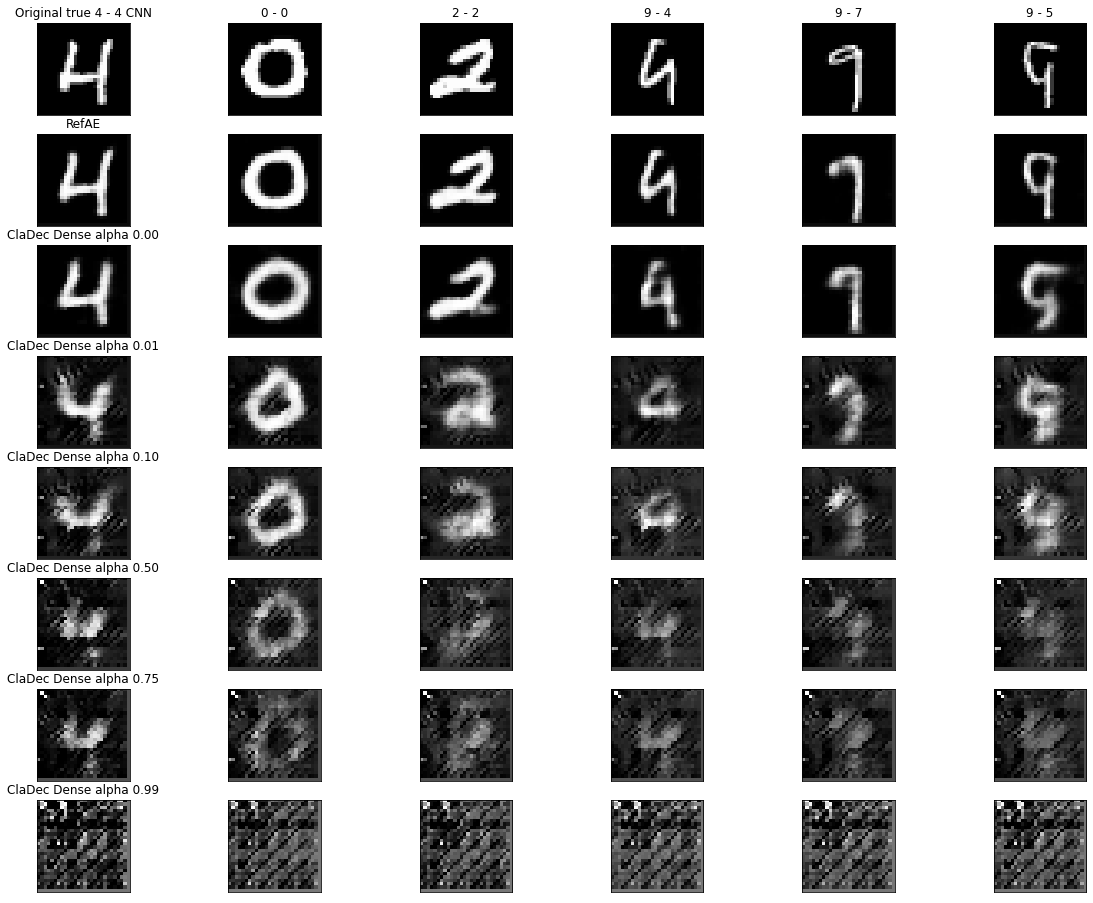

In [9]:
# explaining the dense layer
num_rows = 2 + len(alphas)
plt.figure(figsize=(20, 2 * num_rows))
for i in range(0, n):
    # Display original
    x = i + 1
    ax = plt.subplot(num_rows, n, x)
    title = f'{classes_correct[i]} - {classes_classified[i]}'
    if x == 1:
        ax.set_title("Original true " + title + " CNN")
    else:
        ax.set_title(title)

    plt.imshow(eval_images[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Display refae
    ax = plt.subplot(num_rows, n, x + n)
    if x == 1:
        ax.set_title("RefAE")
    plt.imshow(eval_refae_dense[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Display cladec
    j = 2
    for alpha, data in zip(alphas, cladec_eval_data_dense):
        ax = plt.subplot(num_rows, n, x + j * n)
        j += 1
        if x == 1:
            ax.set_title(f'ClaDec Dense alpha {alpha / 100:0.2f}')
        plt.imshow(data[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
plt.show()

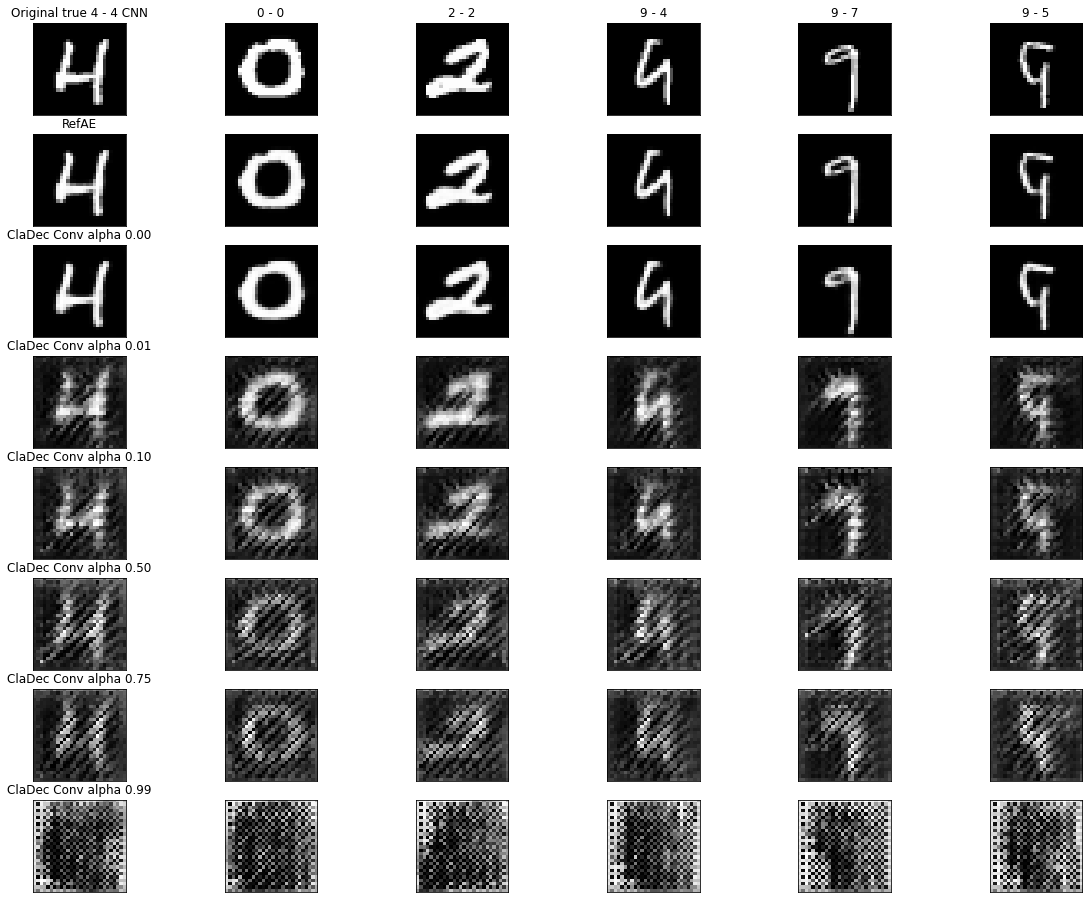

In [10]:
# explaining the conv layer
num_rows = 2 + len(alphas)
plt.figure(figsize=(20, 2 * num_rows))
for i in range(0, n):
    # Display original
    x = i + 1
    ax = plt.subplot(num_rows, n, x)
    title = f'{classes_correct[i]} - {classes_classified[i]}'
    if x == 1:
        ax.set_title("Original true " + title + " CNN")
    else:
        ax.set_title(title)

    plt.imshow(eval_images[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Display refae
    ax = plt.subplot(num_rows, n, x + n)
    if x == 1:
        ax.set_title("RefAE")
    plt.imshow(eval_refae_conv[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Display cladec
    j = 2
    for alpha, data in zip(alphas, cladec_eval_data_conv):
        ax = plt.subplot(num_rows, n, x + j * n)
        j += 1
        if x == 1:
            ax.set_title(f'ClaDec Conv alpha {alpha / 100:0.2f}')
        plt.imshow(data[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
plt.show()

# Evaluation on Classifier

Compare accuracy of the same model trained on data from refAE and ClaDec for alpha=0.0 and alpha=0.9

In [11]:
refae_dense_train = refae_dense.predict(train_images)
refae_dense_test = refae_dense.predict(test_images)

cladec_path = SAVED_CLADEC_PATH.joinpath(' 0').joinpath('dense')
cladec_0_train = get_model_prediction(cladec_path, dense_train_acts)
cladec_0_test = get_model_prediction(cladec_path, dense_test_acts)
cladec_path = SAVED_CLADEC_PATH.joinpath('99').joinpath('dense')
cladec_99_train = get_model_prediction(cladec_path, dense_train_acts)
cladec_99_test = get_model_prediction(cladec_path, dense_test_acts)

2022-05-27 17:27:42.697928: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 188160000 exceeds 10% of free system memory.
2022-05-27 17:27:43.610313: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 188160000 exceeds 10% of free system memory.


1875/1875 [==============================] - 6s 3ms/step


2022-05-27 17:27:50.551648: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 188160000 exceeds 10% of free system memory.


313/313 [==============================] - 1s 2ms/step


In [12]:
model_refae = get_classifier_model_compiled()
model_refae.fit(refae_dense_train, train_labels_c, epochs=10)
model_refae.evaluate(refae_dense_test, test_labels_c)

Epoch 1/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.1769 - categorical_accuracy: 0.9477
Epoch 2/10
1875/1875 [==============================] - 12s 7ms/step - loss: 0.0866 - categorical_accuracy: 0.9745
Epoch 3/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0669 - categorical_accuracy: 0.9793
Epoch 4/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0615 - categorical_accuracy: 0.9807
Epoch 5/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0543 - categorical_accuracy: 0.9831
Epoch 6/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0490 - categorical_accuracy: 0.9846
Epoch 7/10
1875/1875 [==============================] - 12s 7ms/step - loss: 0.0416 - categorical_accuracy: 0.9872
Epoch 8/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0404 - categorical_accuracy: 0.9868
Epoch 9/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0

[0.04483092203736305, 0.9868000149726868]

In [13]:
model_cladec_0 = get_classifier_model_compiled()
model_cladec_0.fit(cladec_0_train, train_labels_c, epochs=10)
model_cladec_0.evaluate(cladec_0_test, test_labels_c)

Epoch 1/10
1875/1875 [==============================] - 13s 6ms/step - loss: 0.1087 - categorical_accuracy: 0.9676
Epoch 2/10
1875/1875 [==============================] - 12s 7ms/step - loss: 0.0496 - categorical_accuracy: 0.9851
Epoch 3/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0393 - categorical_accuracy: 0.9882
Epoch 4/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0330 - categorical_accuracy: 0.9902
Epoch 5/10
1875/1875 [==============================] - 12s 7ms/step - loss: 0.0305 - categorical_accuracy: 0.9909
Epoch 6/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0263 - categorical_accuracy: 0.9917
Epoch 7/10
1875/1875 [==============================] - 12s 7ms/step - loss: 0.0234 - categorical_accuracy: 0.9930
Epoch 8/10
1875/1875 [==============================] - 12s 7ms/step - loss: 0.0211 - categorical_accuracy: 0.9935
Epoch 9/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0

[0.06518620997667313, 0.9869999885559082]

In [14]:
model_cladec_99 = get_classifier_model_compiled()
model_cladec_99.fit(cladec_99_train, train_labels_c, epochs=10)
model_cladec_99.evaluate(cladec_99_test, test_labels_c)

Epoch 1/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.1008 - categorical_accuracy: 0.9713
Epoch 2/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0428 - categorical_accuracy: 0.9870
Epoch 3/10
1875/1875 [==============================] - 12s 7ms/step - loss: 0.0319 - categorical_accuracy: 0.9904
Epoch 4/10
1875/1875 [==============================] - 12s 7ms/step - loss: 0.0296 - categorical_accuracy: 0.9913
Epoch 5/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0288 - categorical_accuracy: 0.9914
Epoch 6/10
1875/1875 [==============================] - 12s 7ms/step - loss: 0.0223 - categorical_accuracy: 0.9935
Epoch 7/10
1875/1875 [==============================] - 12s 7ms/step - loss: 0.0227 - categorical_accuracy: 0.9932
Epoch 8/10
1875/1875 [==============================] - 12s 7ms/step - loss: 0.0191 - categorical_accuracy: 0.9940
Epoch 9/10
1875/1875 [==============================] - 12s 7ms/step - loss: 0.0

[0.043966662138700485, 0.9894999861717224]

In [15]:
classifier.evaluate(test_images, test_labels_c)

313/313 [==============================] - 1s 4ms/step - loss: 0.0367 - categorical_accuracy: 0.9899


[0.03668462485074997, 0.9898999929428101]